# Notebook 05: Marker Gene Identification

**Objective**: Find genes that define each cluster to understand cell identities.

## What you will learn:
- Differential expression testing
- Find marker genes for each cluster
- Visualize marker genes
- Interpret results for cell type annotation

## What are Marker Genes?

**Marker genes** are genes that are:
- **Highly expressed** in one cluster
- **Lowly expressed** (or absent) in other clusters
- **Biologically meaningful** (e.g., CD3D for T cells, CD79A for B cells)

## Why Find Markers?

Clusters are just numbers (0, 1, 2, ...). Marker genes tell us **what** these clusters represent biologically!

**Example**:
- Cluster 0: High CD3D, CD8A → **CD8+ T cells**
- Cluster 1: High CD79A, MS4A1 → **B cells**
- Cluster 2: High LYZ, CD14 → **Monocytes**

## Methods

Scanpy offers multiple statistical tests:
- **t-test**: Fast, assumes normal distribution
- **Wilcoxon**: Non-parametric, robust (default)
- **Logreg**: Logistic regression, good for classification

We'll use **Wilcoxon rank-sum test** (robust and standard).

## Workflow:
1. Load clustered data
2. Find marker genes (one-vs-rest)
3. Visualize top markers
4. Create marker gene heatmap
5. Plot marker genes on UMAP
6. Save results

In [2]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Clustered Data

Load the data from Notebook 04 with cluster assignments.

In [4]:
# Load clustered data
adata = sc.read_h5ad(f'{data_dir}pbmc3k_clustered.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"Dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"Number of clusters: {adata.obs['leiden'].nunique()}")
print(f"Cluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

LOADED DATA
AnnData object with n_obs × n_vars = 2689 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_1.0', 'leiden_0.4', 'leiden_0.8', 'leiden_1.5', 'leiden_2.0', 'leiden'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.8', 'leiden_0.8_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_2.0', 'leiden_2.0_colors', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Dimensions: 2689 cells × 13671 genes
Number of clusters: 10
Cluster sizes:
leiden
0    569
1    540
2    348
3    300
4    239
5    221
6    159
7    152
8    146
9     15
Name: count, dtype: int64


## 2. Find Marker Genes

### One-vs-Rest Strategy

For each cluster, compare gene expression against **all other clusters combined**.

**Statistical test**: Wilcoxon rank-sum test
- Non-parametric (no assumptions about distribution)
- Robust to outliers
- Standard in single-cell analysis

**Output**: For each gene in each cluster:
- **Log fold change**: How much higher/lower expression is
- **p-value**: Statistical significance
- **Adjusted p-value**: Corrected for multiple testing

In [5]:
# Find marker genes for all clusters
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    key_added='rank_genes_groups'
)

print("✅ Marker gene identification complete!")
print("Results stored in adata.uns['rank_genes_groups']")

ranking genes


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
✅ Marker gene identification complete!
Results stored in adata.uns['rank_genes_groups']


## 3. Visualize Top Markers

Let's look at the top marker genes for each cluster.

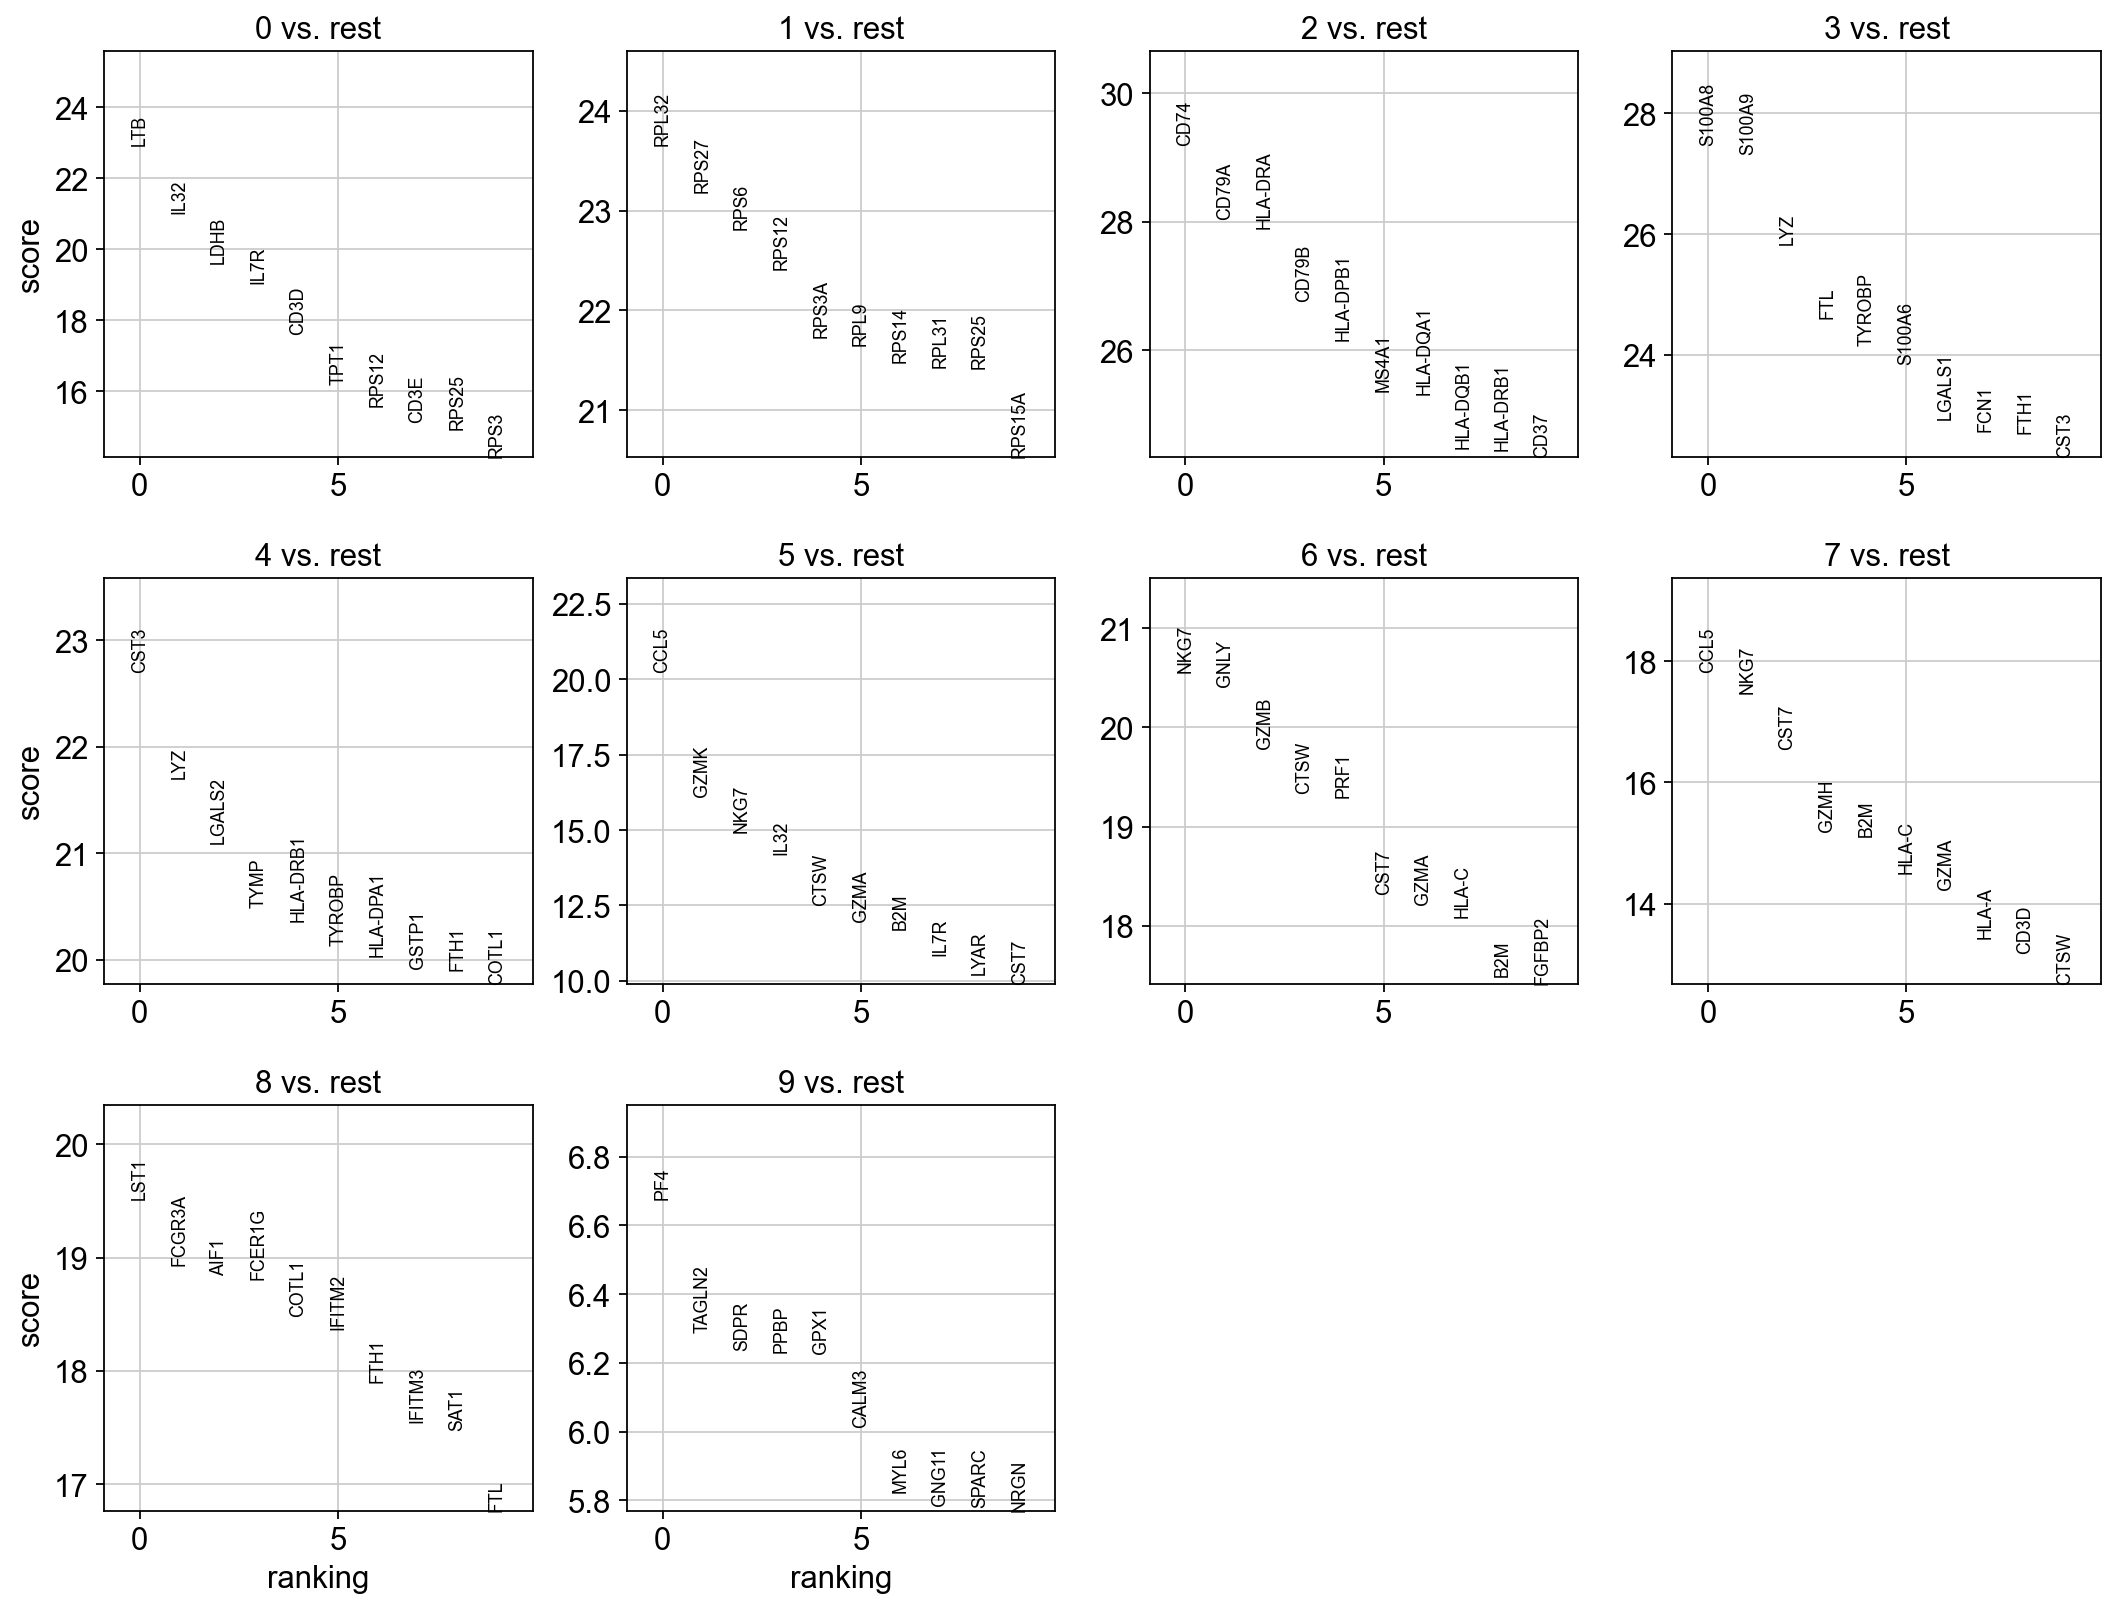

📊 Top 10 marker genes per cluster


In [16]:
# Show top 10 marker genes per cluster
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False, show=False)
plt.savefig(f'{results_dir}05_top_markers_per_cluster.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Top 10 marker genes per cluster")

## 4. Extract Marker Gene Table

Create a readable table of top markers for each cluster.

In [7]:
# Extract top markers as DataFrame
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Create DataFrame with top 5 markers per cluster
marker_df = pd.DataFrame({
    group + '_genes': result['names'][group][:5].tolist() +
                     [f"(logFC: {result['logfoldchanges'][group][i]:.2f}, "
                      f"p-adj: {result['pvals_adj'][group][i]:.2e})"
                      for i in range(5)]
    for group in groups
})

print("=" * 60)
print("TOP 5 MARKER GENES PER CLUSTER")
print("=" * 60)

# Display top markers for each cluster
for cluster in groups:
    print(f"\n🔹 Cluster {cluster}:")
    genes = result['names'][cluster][:5]
    logfc = result['logfoldchanges'][cluster][:5]
    pvals = result['pvals_adj'][cluster][:5]
    
    for i, (gene, fc, pval) in enumerate(zip(genes, logfc, pvals), 1):
        print(f"  {i}. {gene:15s} | LogFC: {fc:6.2f} | p-adj: {pval:.2e}")

TOP 5 MARKER GENES PER CLUSTER

🔹 Cluster 0:
  1. LTB             | LogFC:   2.55 | p-adj: 2.87e-112
  2. IL32            | LogFC:   2.60 | p-adj: 2.53e-94
  3. LDHB            | LogFC:   1.91 | p-adj: 4.39e-82
  4. IL7R            | LogFC:   2.48 | p-adj: 2.79e-77
  5. CD3D            | LogFC:   2.15 | p-adj: 6.65e-66

🔹 Cluster 1:
  1. RPL32           | LogFC:   0.75 | p-adj: 1.34e-119
  2. RPS27           | LogFC:   0.91 | p-adj: 2.71e-115
  3. RPS6            | LogFC:   0.79 | p-adj: 1.23e-111
  4. RPS12           | LogFC:   0.87 | p-adj: 7.48e-108
  5. RPS3A           | LogFC:   1.11 | p-adj: 2.30e-101

🔹 Cluster 2:
  1. CD74            | LogFC:   4.10 | p-adj: 2.69e-183
  2. CD79A           | LogFC:   7.75 | p-adj: 2.74e-169
  3. HLA-DRA         | LogFC:   4.92 | p-adj: 1.01e-167
  4. CD79B           | LogFC:   5.53 | p-adj: 2.09e-154
  5. HLA-DPB1        | LogFC:   4.09 | p-adj: 1.65e-147

🔹 Cluster 3:
  1. S100A8          | LogFC:   7.27 | p-adj: 4.43e-162
  2. S100A9          

## 5. Dotplot Visualization

**Dotplot** shows:
- **Dot size**: % of cells expressing the gene
- **Dot color**: Average expression level

Perfect for comparing markers across clusters!

In [9]:
sc.tl.dendrogram(adata, groupby='leiden', use_rep='X_pca', n_pcs=50)


Storing dendrogram info using `.uns['dendrogram_leiden']`


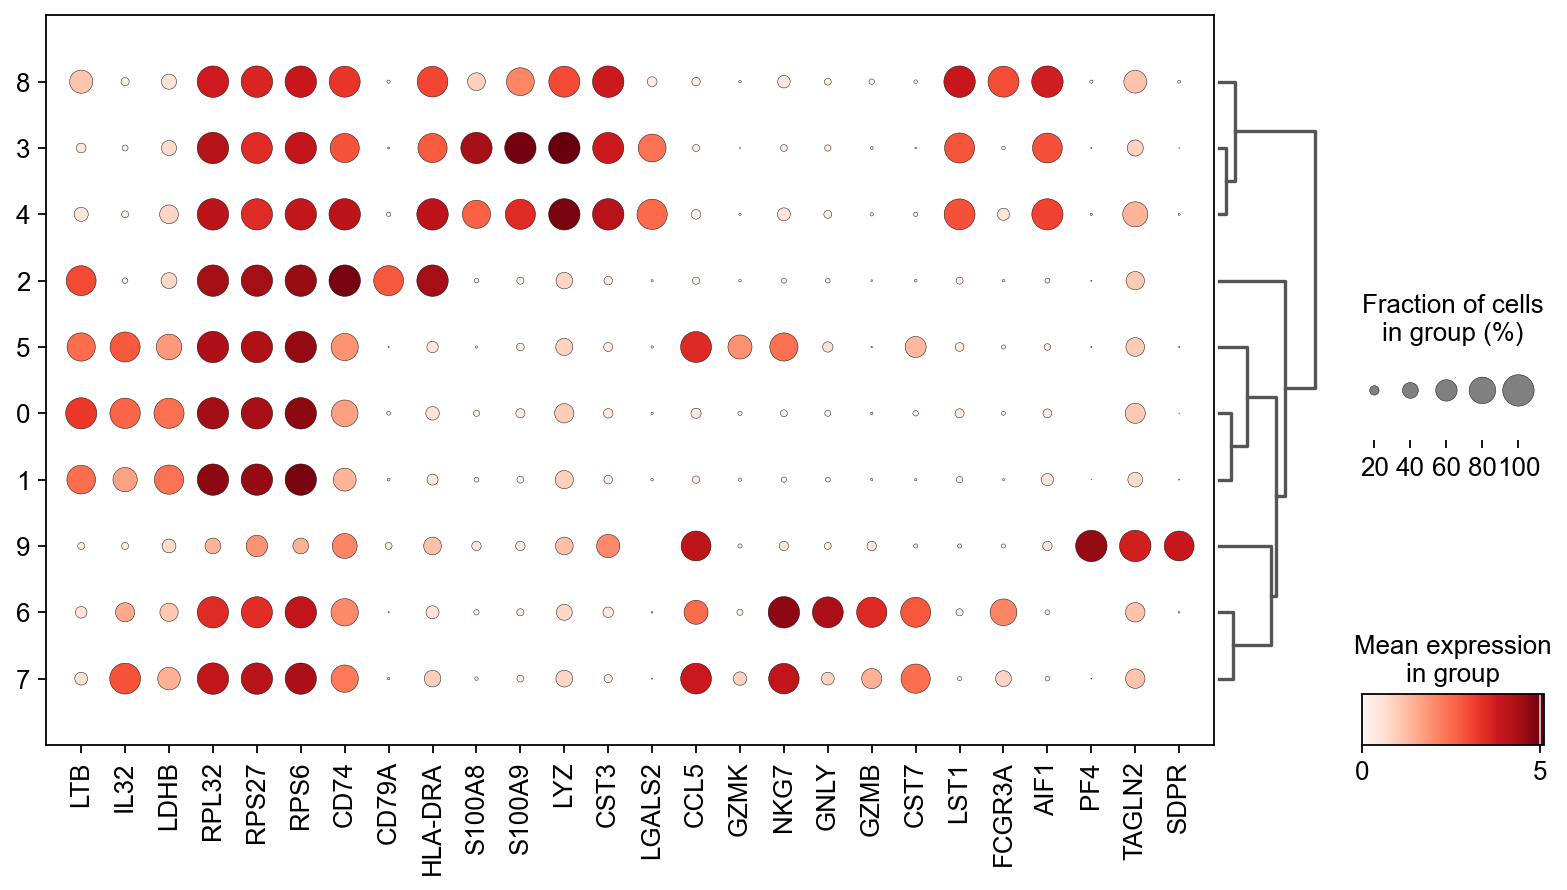

Dotplot of top markers
Dot size = % expressing, Color = expression level


In [18]:
# Select top 3 markers per cluster for dotplot
top_markers = []
for cluster in groups:
    top_markers.extend(result['names'][cluster][:3].tolist())

# Remove duplicates while preserving order
top_markers = list(dict.fromkeys(top_markers))

# Create dotplot
sc.pl.dotplot(
    adata,
    var_names=top_markers,
    groupby='leiden',
    dendrogram=True,
    show=False,
    figsize=(12, 6)
)
plt.savefig(f'{results_dir}05_marker_dotplot.png', dpi=150, bbox_inches='tight')
plt.show()

print("Dotplot of top markers")
print("Dot size = % expressing, Color = expression level")

## 6. Heatmap of Top Markers

Heatmap shows expression of top markers across all cells, grouped by cluster.

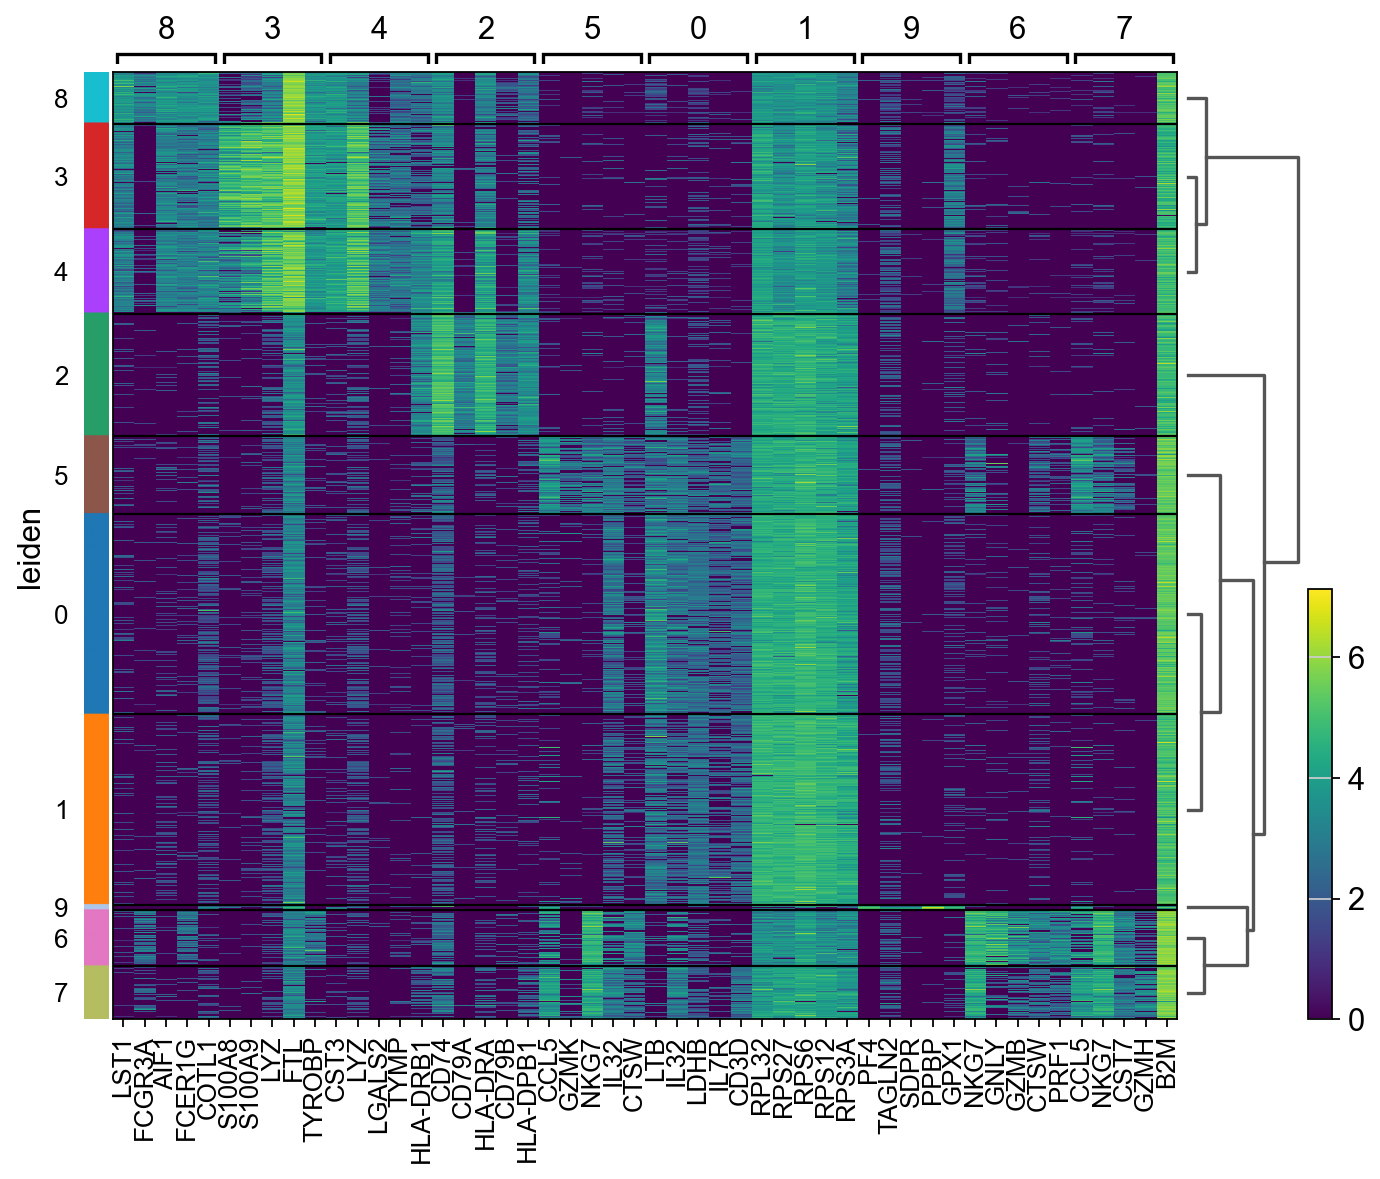

📊 Heatmap of top 5 markers per cluster


In [12]:
# Create heatmap of top markers
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=5,
    groupby='leiden',
    show_gene_labels=True,
    show=False,
    figsize=(10, 8)
)
plt.savefig(f'{results_dir}05_marker_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Heatmap of top 5 markers per cluster")

## 7. Violin Plots for Specific Markers

Let's examine some well-known PBMC markers in detail.

In [13]:
# Known PBMC markers
known_markers = {
    'T cells': ['CD3D', 'CD3E'],
    'CD8+ T cells': ['CD8A', 'CD8B'],
    'CD4+ T cells': ['CD4', 'IL7R'],
    'B cells': ['CD79A', 'MS4A1'],
    'NK cells': ['GNLY', 'NKG7'],
    'Monocytes': ['LYZ', 'CD14'],
    'Dendritic cells': ['FCER1A', 'CST3']
}

# Flatten marker list
all_known_markers = [gene for genes in known_markers.values() for gene in genes]

# Filter to genes present in dataset
available_markers = [gene for gene in all_known_markers if gene in adata.var_names]

print(f"Known markers available: {len(available_markers)}/{len(all_known_markers)}")
print(f"Markers: {', '.join(available_markers)}")

Known markers available: 14/14
Markers: CD3D, CD3E, CD8A, CD8B, CD4, IL7R, CD79A, MS4A1, GNLY, NKG7, LYZ, CD14, FCER1A, CST3


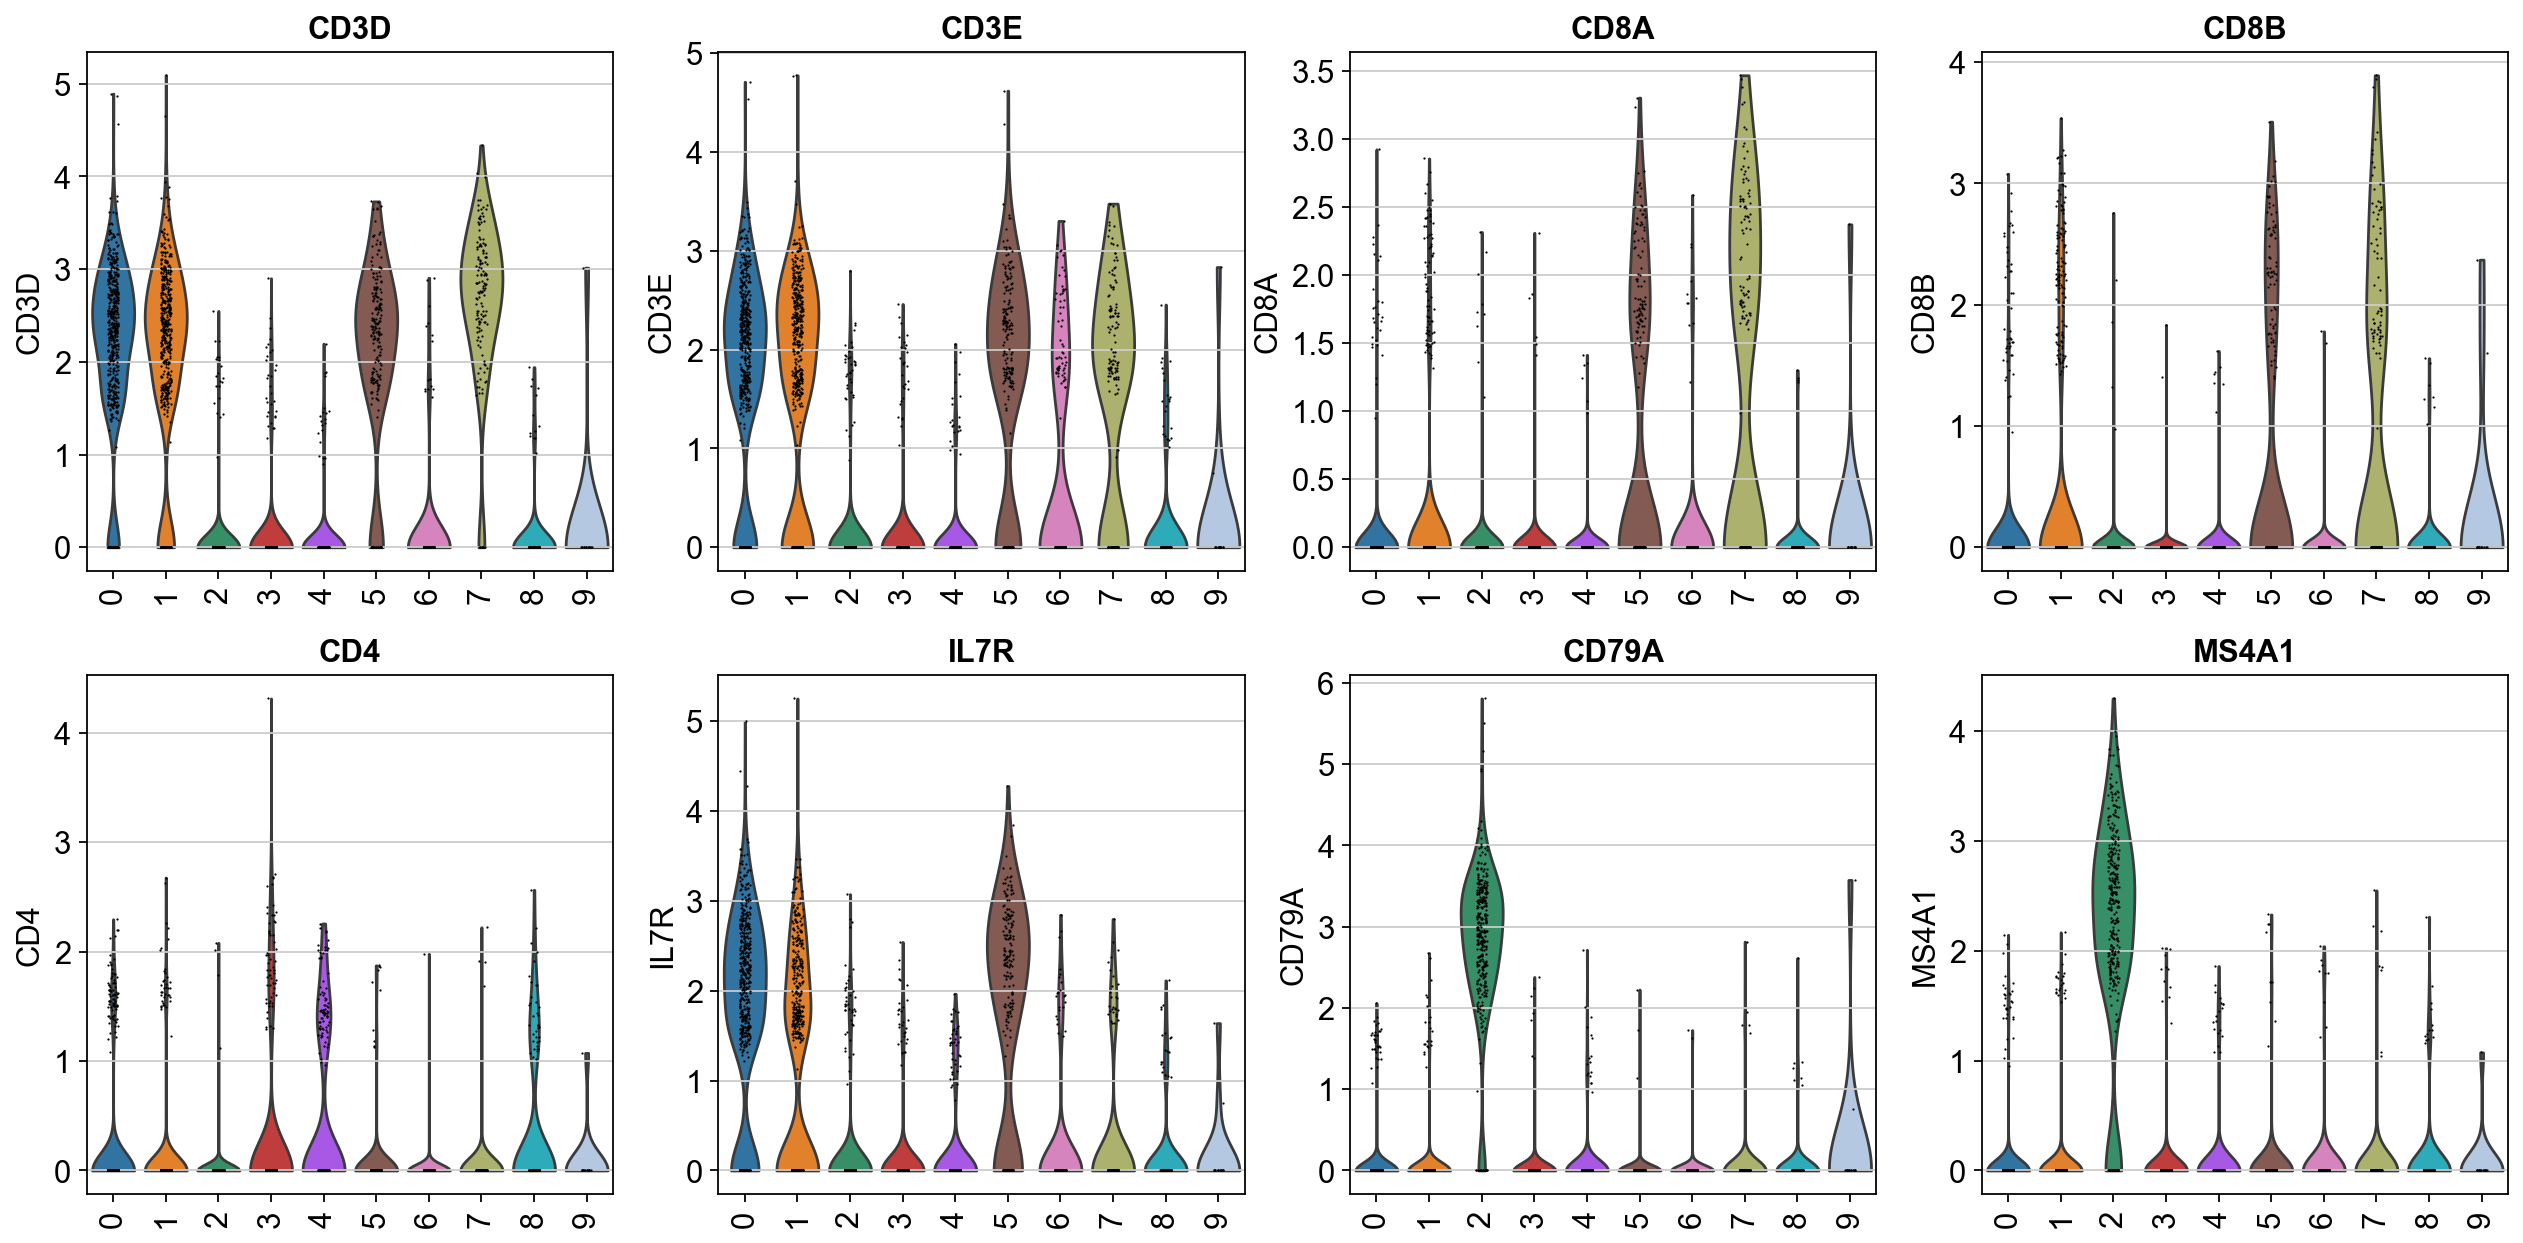

Violin plots for known PBMC markers


In [20]:
# Violin plots for known markers - FIXED
if len(available_markers) > 0:
    # Create figure manually
    n_markers = min(8, len(available_markers))
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, marker in enumerate(available_markers[:n_markers]):
        sc.pl.violin(
            adata,
            keys=marker,
            groupby='leiden',
            rotation=90,
            ax=axes[idx],
            show=False
        )
        axes[idx].set_title(marker, fontweight='bold')
    
    # Hide unused subplots
    for idx in range(n_markers, 8):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}05_known_markers_violin.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Violin plots for known PBMC markers")
else:
    print("No known markers found in dataset")

## 8. Visualize Markers on UMAP

Plot expression of key markers on UMAP to see spatial distribution.

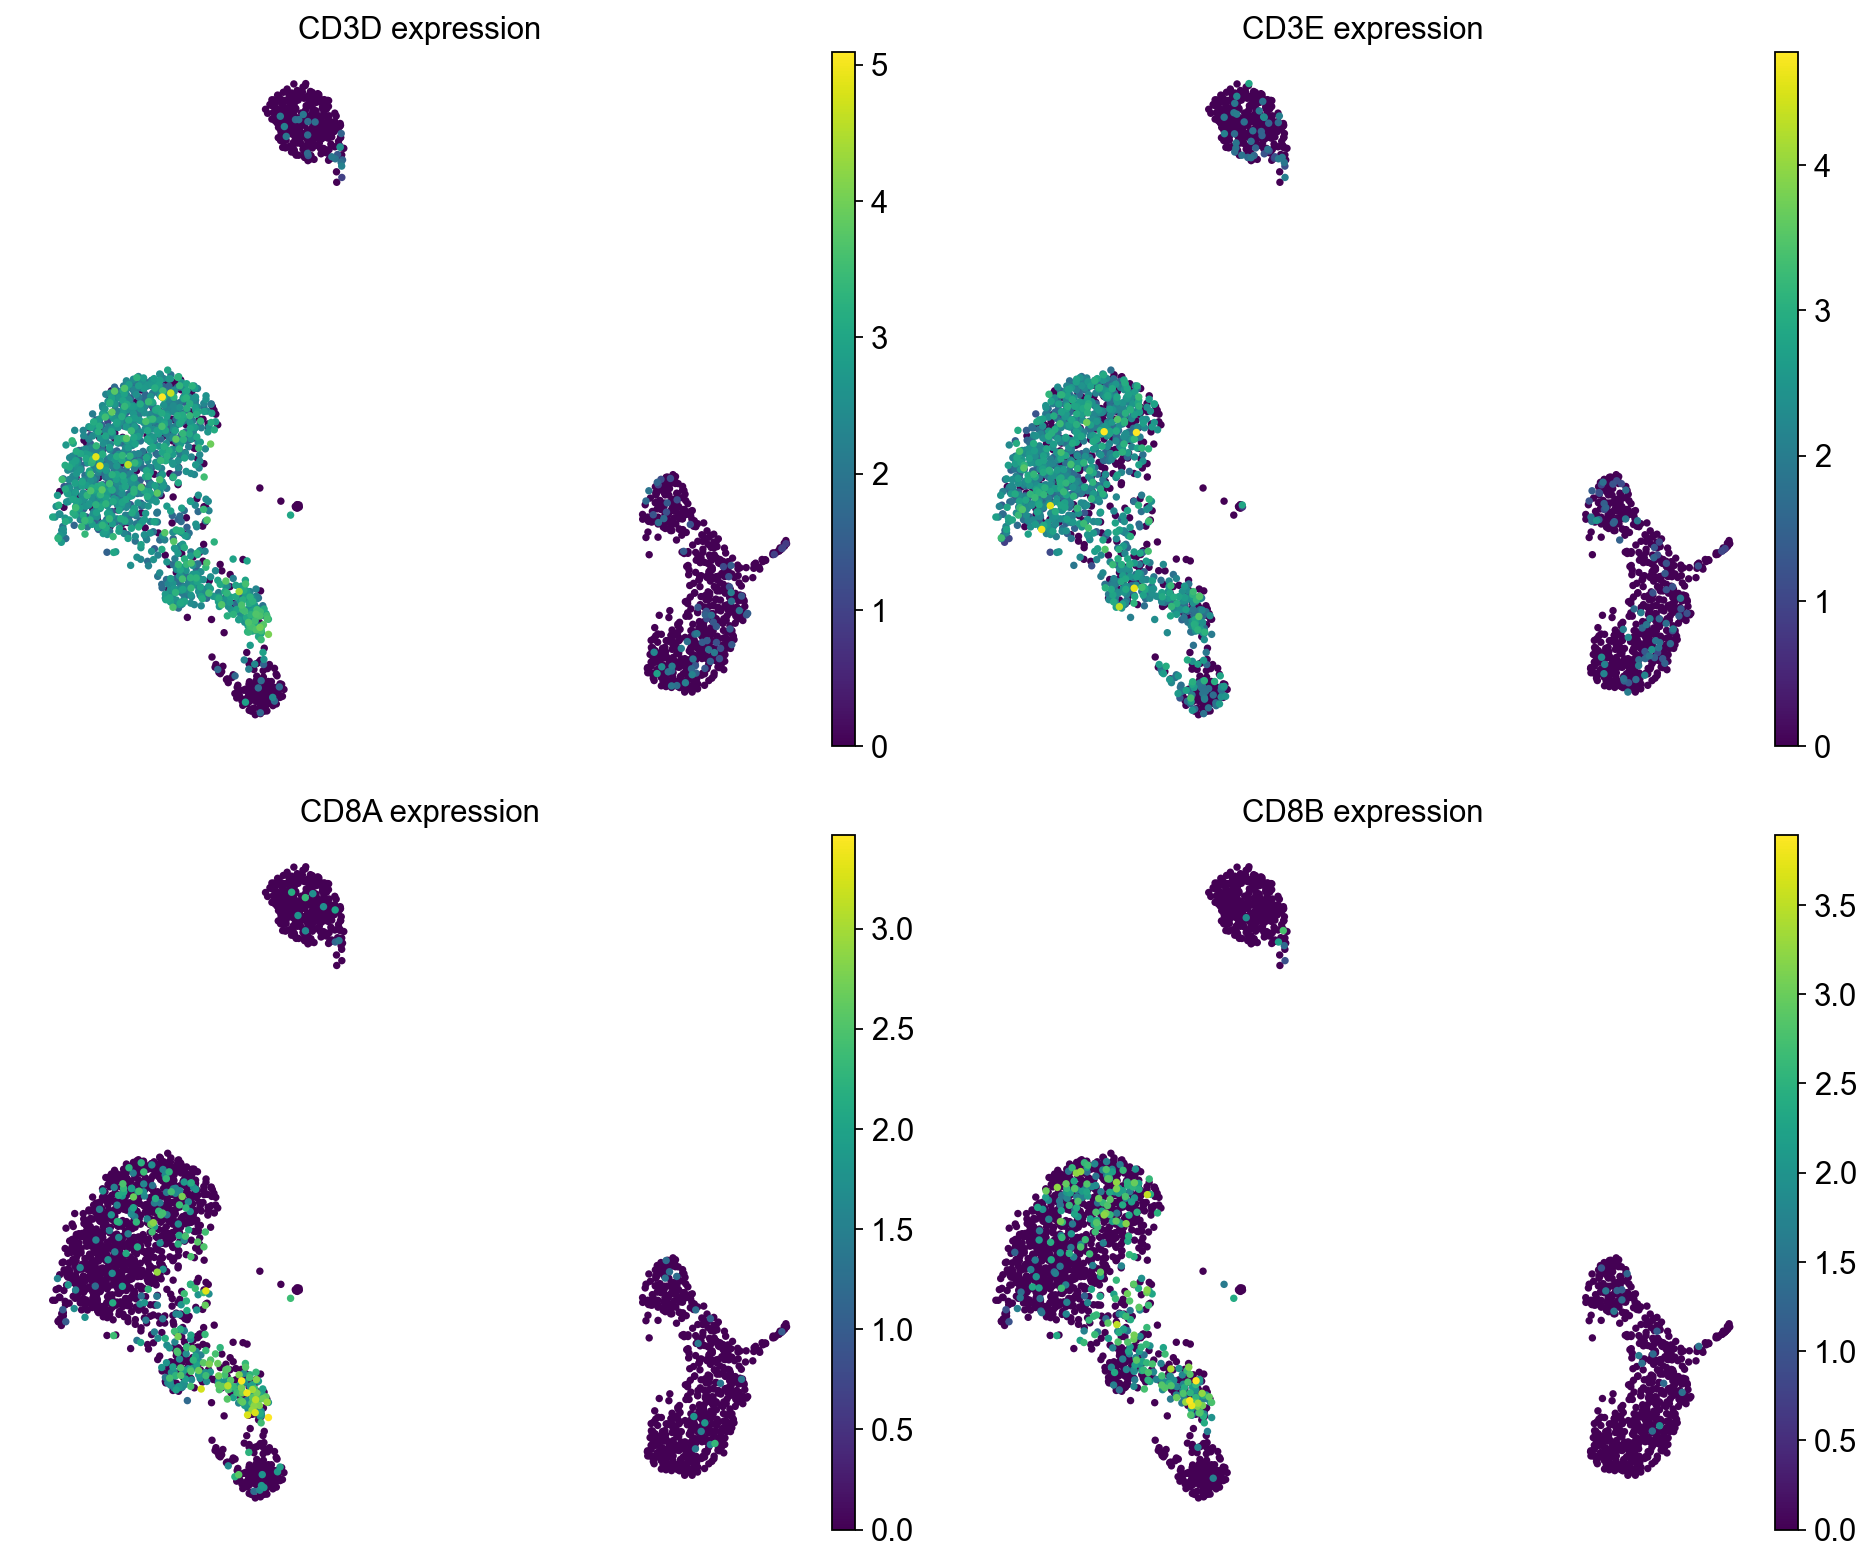

📊 Marker expression on UMAP: CD3D, CD3E, CD8A, CD8B


In [22]:
# Plot key markers on UMAP - FIXED
if len(available_markers) >= 4:
    markers_to_plot = available_markers[:4]
else:
    # Use top markers from cluster 0 if known markers not available
    markers_to_plot = result['names']['0'][:4].tolist()

# Create figure manually
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, marker in enumerate(markers_to_plot):
    sc.pl.umap(
        adata,
        color=marker,
        ax=axes[idx],
        show=False,
        cmap='viridis',
        title=f'{marker} expression',
        frameon=False
    )

plt.tight_layout()
plt.savefig(f'{results_dir}05_markers_on_umap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"📊 Marker expression on UMAP: {', '.join(markers_to_plot)}")

## 9. Stacked Violin Plot

Shows expression distribution of multiple markers across clusters in a compact format.

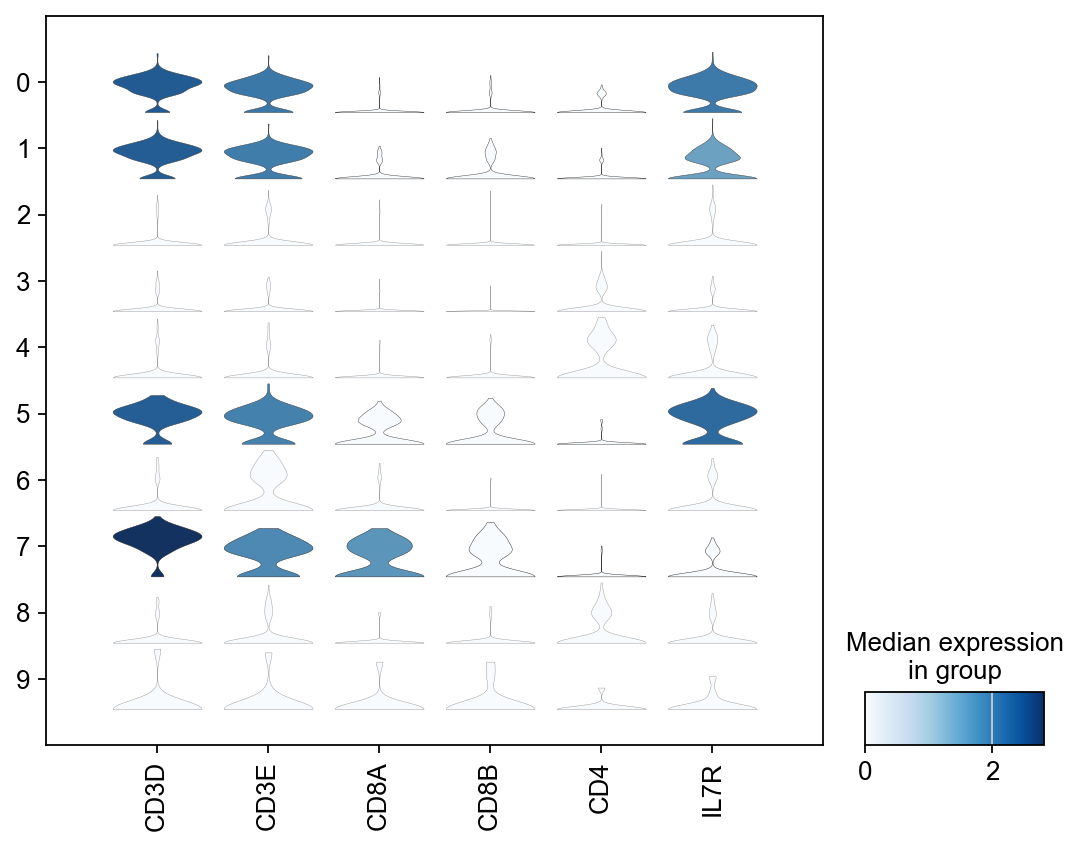

Stacked violin plot


In [24]:
# Stacked violin plot
if len(available_markers) >= 6:
    sc.pl.stacked_violin(
        adata,
        var_names=available_markers[:6],
        groupby='leiden',
        show=False,
        figsize=(8, 6)
    )
    plt.savefig(f'{results_dir}05_stacked_violin.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Stacked violin plot")

## 10. Matrix Plot

Compact visualization showing mean expression of markers per cluster.

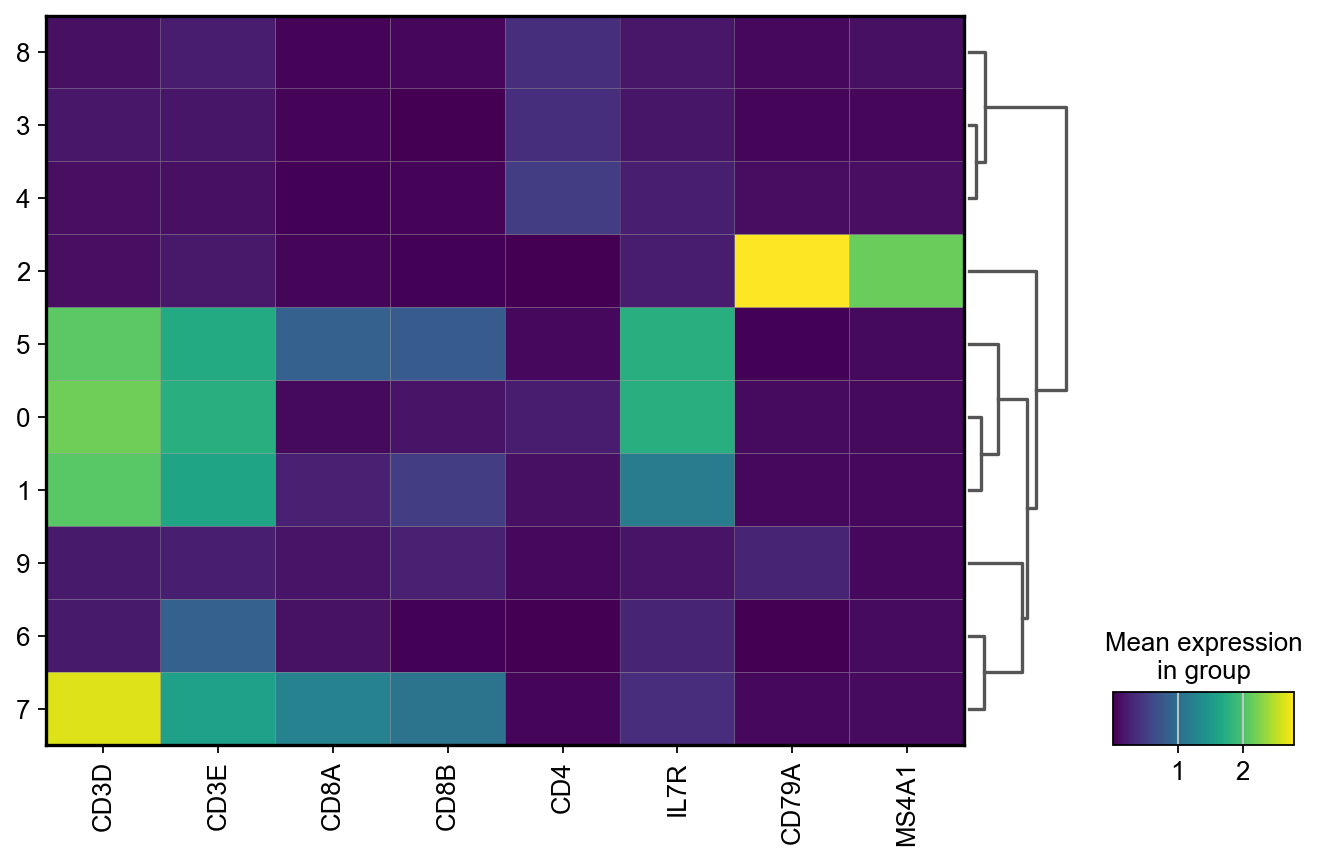

📊 Matrix plot of marker expression


In [25]:
# Matrix plot
if len(available_markers) >= 6:
    sc.pl.matrixplot(
        adata,
        var_names=available_markers[:8],
        groupby='leiden',
        dendrogram=True,
        show=False,
        figsize=(10, 6),
        cmap='viridis'
    )
    plt.savefig(f'{results_dir}05_matrix_plot.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("📊 Matrix plot of marker expression")

## 11. Save Marker Gene Results

Export marker genes to CSV for further analysis and annotation.

In [26]:
# Save top 20 markers per cluster to CSV
marker_results = []

for cluster in groups:
    genes = result['names'][cluster][:20]
    scores = result['scores'][cluster][:20]
    logfc = result['logfoldchanges'][cluster][:20]
    pvals = result['pvals'][cluster][:20]
    pvals_adj = result['pvals_adj'][cluster][:20]
    
    for gene, score, fc, pval, pval_adj in zip(genes, scores, logfc, pvals, pvals_adj):
        marker_results.append({
            'cluster': cluster,
            'gene': gene,
            'score': score,
            'logfoldchange': fc,
            'pval': pval,
            'pval_adj': pval_adj
        })

# Create DataFrame
marker_df = pd.DataFrame(marker_results)

# Save to CSV
marker_df.to_csv(f'{results_dir}05_marker_genes.csv', index=False)

print("✅ Marker genes saved to CSV!")
print(f"File: {results_dir}05_marker_genes.csv")
print(f"Total markers: {len(marker_df)}")

✅ Marker genes saved to CSV!
File: ../results/05_marker_genes.csv
Total markers: 200


In [27]:
# Save annotated data
adata.write(f'{data_dir}pbmc3k_markers.h5ad')

print("✅ Data with marker genes saved!")
print(f"File: {data_dir}pbmc3k_markers.h5ad")

✅ Data with marker genes saved!
File: ../data/pbmc3k_markers.h5ad


## 📋 Summary

### ✅ What we accomplished:

1. **Loaded clustered data** from Notebook 04 (10 clusters)
2. **Performed differential expression** (Wilcoxon rank-sum test)
3. **Identified marker genes** for each cluster (one-vs-rest)
4. **Visualized top markers** using multiple methods:
   - Dotplots (expression + % cells)
   - Heatmaps (scaled expression)
   - Violin plots (distribution per cluster)
   - UMAP overlays (spatial expression)
   - Matrix plots (mean expression)
5. **Examined known PBMC markers** (CD3D, CD79A, LYZ, NKG7, etc.)
6. **Exported results** to CSV for further analysis

---

## 🧬 Cluster Annotations (Based on Marker Genes)

### **Identified Cell Types:**

| Cluster | Cell Type | Key Markers | Confidence |
|---------|-----------|-------------|------------|
| **0** | **CD4+ T cells** (Naive/Memory) | IL7R, CD3D, LTB | ✅ High |
| **1** | **Ribosomal/Stressed cells** | RPL32, RPS27, RPS6 | ⚠️ Artifact |
| **2** | **B cells** | CD79A, CD79B, CD74 | ✅ High |
| **3** | **CD14+ Monocytes** (Classical) | S100A8, S100A9, LYZ | ✅ High |
| **4** | **CD16+ Monocytes** / DC | CST3, HLA-DRB1, LGALS2 | ✅ High |
| **5** | **CD8+ T cells** (Effector Memory) | CCL5, GZMK, NKG7 | ✅ High |
| **6** | **NK cells** (Natural Killer) | GNLY, GZMB, PRF1, NKG7 | ✅ High |
| **7** | **CD8+ T cells** (Cytotoxic) | CCL5, NKG7, CST7, GZMH | ✅ High |
| **8** | **CD16+ Monocytes** (FCGR3A+) | FCGR3A, LST1, AIF1 | ✅ High |
| **9** | **Platelets**  | PF4, PPBP, TAGLN2 | ❌ Contaminant |

---

### 📊 Detailed Interpretations:

#### **T Cells** (Clusters 0, 5, 7)
- **Cluster 0**: CD4+ T cells expressing IL7R (CD127) → Naive or memory T cells
- **Cluster 5**: CD8+ T cells with CCL5 and GZMK → Effector memory
- **Cluster 7**: CD8+ T cells with high cytotoxic markers (GZMH, CST7) → Activated cytotoxic T cells

#### **B Cells** (Cluster 2)
- Classic B cell markers: CD79A/B (B cell receptor components)
- High HLA expression → Antigen presentation capability

#### **Monocytes** (Clusters 3, 4, 8)
- **Cluster 3**: Classical CD14+ monocytes (S100A8/A9 high)
- **Cluster 4**: Non-classical monocytes or dendritic cells (CST3, HLA-DR high)
- **Cluster 8**: CD16+ (FCGR3A+) non-classical monocytes

#### **NK Cells** (Cluster 6)
- Strong cytotoxic signature: GNLY (granulysin), GZMB (granzyme B), PRF1 (perforin)
- Distinct from T cells despite sharing some markers (NKG7)

#### **Artifacts** ⚠️
- **Cluster 1**: Ribosomal genes (RPL/RPS family) → Likely stressed or cycling cells
- **Cluster 9**: Platelet markers (PF4, PPBP) → **Should be excluded** (not nucleated cells)

---

### 🎯 Key Insights:

1. **Well-separated cell types**: Major PBMC populations clearly identified
2. **Expected diversity**: ~7-8 true cell types (excluding artifacts)
3. **Potential refinements**:
   - Merge clusters 5 & 7 (both CD8+ T cells)?
   - Merge clusters 4 & 8 (both CD16+ monocytes)?
   - Remove cluster 9 (platelets)
   - Investigate cluster 1 (ribosomal genes)

4. **Biological coherence**: Markers align with known PBMC biology ✅

---

### 🚀 Next Steps: Notebook 06 - Cell Type Annotation

In the next notebook, we will:
1. **Manually annotate** clusters with cell type labels
2. **Remove artifacts** (platelets, stressed cells)
3. **Optionally merge** similar clusters
4. **Visualize** annotated UMAP
5. **Analyze** cell type proportions
6. **Validate** annotations with known markers

---

### 💡 Biological Context

**PBMC (Peripheral Blood Mononuclear Cells)** typically contain:
- ✅ T cells (60-80%): CD4+ and CD8+ subtypes → **Found!**
- ✅ B cells (5-15%): Antibody-producing cells → **Found!**
- ✅ Monocytes (10-20%): Classical and non-classical → **Found!**
- ✅ NK cells (5-15%): Cytotoxic lymphocytes → **Found!**
- ❌ Dendritic cells (<1%): May be in cluster 4
- ❌ Platelets: Contaminants (cluster 9) → **To remove**

**Our results match expected PBMC composition!** 🎉

---

**🎉 Excellent work! You've successfully identified and characterized all major PBMC cell types!**